In [1]:
from numpy import * 
from matplotlib.pyplot import *
from subprocess import check_output,CalledProcessError

In [2]:
import os
import glob
import numpy as np

def read_tpetra_output(label, nx, ny, directory='.'):
    """
    Reads multiple Tpetra vector output files of the form 'label_<rank>.out'
    and returns a 2D NumPy array of shape (nx, ny).

    Parameters:
        label (str): The prefix label used in the file names (e.g., "rhs").
        nx (int): Number of grid points in x-direction.
        ny (int): Number of grid points in y-direction.
        directory (str): Directory where the files are located (default: current).

    Returns:
        np.ndarray: Assembled 2D array of shape (nx, ny).
    """
    data = np.zeros((nx, ny))

    # Find all matching files
    pattern = os.path.join(directory, f"{label}_*.out")
    files = glob.glob(pattern)

    if not files:
        raise FileNotFoundError(f"No files found with pattern: {pattern}")

    for filename in files:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip().strip('()')
                if not line:
                    continue
                i_str, j_str, val_str = line.split(',')
                i = int(i_str.strip())
                j = int(j_str.strip())
                value = float(val_str.strip())
                data[i, j] = value

    return data

In [3]:
import math
import numpy as np

PI = math.pi

def phi_exact(x, y):
    return -1*math.sin(PI * x) * math.sin(PI * y)

import numpy as np


def calculate_n(x, y):
    return 0.1 + np.sin(2 * np.pi * x)**2 + np.sin(2 * np.pi * y)**2

def calculate_rho(x, y):
    pi = np.pi
    sin_px = np.sin(pi * x)
    cos_px = np.cos(pi * x)
    sin_py = np.sin(pi * y)
    cos_py = np.cos(pi * y)
    sin_2px = np.sin(2 * pi * x)
    cos_2px = np.cos(2 * pi * x)
    sin_2py = np.sin(2 * pi * y)
    cos_2py = np.cos(2 * pi * y)

    term1 = 4 * pi**2 * cos_px * cos_2px * sin_2px * sin_py
    term2 = 4 * pi**2 * cos_py * cos_2py * sin_px * sin_2py
    term3 = -2 * pi**2 * sin_px * sin_py * (0.1 + sin_2px**2 + sin_2py**2)

    return term1 + term2 + term3

def calculate_rho_const(x,y):
    return -2*pi*pi*sin(pi*x) * sin(pi*y)

In [4]:
def get_error(numerical_data, analytical_data0):
    return amax(abs(analytical_data0 - numerical_data))
    return sqrt(mean((analytical_data0 - numerical_data)**2))

In [5]:

def plot_comparison(numerical_data, analytical_data_evaluated, x, y, X, Y_grid, title_prefix="Value"):
    fig, ax = subplots(1, 3, figsize=(18, 6))


    im0 = ax[0].pcolor(x, y, numerical_data, shading='auto')
    ax[0].set_title(f'Numerical {title_prefix} (Tpetra Output)')
    colorbar(im0, ax=ax[0], label=f'{title_prefix} value')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_aspect('equal')


    im1 = ax[1].pcolor(x, y, analytical_data_evaluated, shading='auto')
    ax[1].set_title(f'Analytical {title_prefix}')
    colorbar(im1, ax=ax[1], label=f'{title_prefix} value')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].set_aspect('equal')


    im2 = ax[2].pcolor(x, y, abs(analytical_data_evaluated - numerical_data), shading='auto')
    ax[2].set_title(f'Difference (Analytical - Numerical {title_prefix})')
    colorbar(im2, ax=ax[2], label=f'Difference in {title_prefix}')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')
    ax[2].set_aspect('equal')


    print(f'Maximum error in {title_prefix}: {get_error(numerical_data, analytical_data_evaluated)}')

    tight_layout()
    show()


In [6]:
import re

def parse_belos_solver_summary(stdout: str):
    iterations = None
    final_residual = None
    solve_time_seconds = None

    # Regex to capture iterations and final residual
    # Made this more robust to handle additional lines before the "Converged" status.
    final_convergence_match = re.findall(
        r"Number of Iterations = (\d+)\s*< 500\s*(?:.|\n)*?" # Match "Number of Iterations = X < 500" and any lines in between (non-greedy)
        r"\.\.\.\.(?:.|\n)*?"                       # Match "Converged...." and any lines in between (non-greedy)
        r"residual \[ 0 \] = ([\d\.eE\-\+]+)",              # Capture the residual
        stdout, re.DOTALL
    )[-1]

    if final_convergence_match:
        iterations = int(final_convergence_match[0])
        final_residual = float(final_convergence_match[1])

    # Regex to capture the total solve time (this part remains robust as it was)
    time_match = re.search(
        r"TimeMonitor results over \d+ processor.*?" # Find the start of the TimeMonitor block
        r"total solve time\s+([\d\.eE\-\+]+)",       # Look for "total solve time" and capture the number
        stdout, re.DOTALL | re.IGNORECASE # re.DOTALL allows '.' to match newlines, re.IGNORECASE makes "total solve time" case-insensitive
    )

    if time_match:
        solve_time_seconds = float(time_match.group(1))

    return iterations, final_residual, solve_time_seconds


In [7]:
import os
from subprocess import run, PIPE, STDOUT

def run_poisson_solver(nmpi, nx, ny, solver, generalized, test_analytical, nthreads=1):
    os.system("rm -f *.out")

    os.environ["OMP_NUM_THREADS"] = str(nthreads)
    os.environ["OMP_PROC_BIND"] = "spread"
    os.environ["OMP_PLACES"] = "threads"
    command = [
        "mpirun", "-n", str(nmpi), "../build/Poisson",
        f"--nx={nx}", f"--ny={ny}", f"--solver={solver}"
    ]

    if generalized:
        command.append("--generalized")
    if test_analytical:
        command.append("--test_analytical")

    result = run(command, check=True, capture_output=True, text=True)

    if result.stderr:
        print("Solver produced stderr output:")
        print(result.stderr)

    return result.stdout

def plot_convergence(errors_data, title_text):
    errors = array(errors_data)
    loglog(errors[:, 0], errors[:, 1], marker='o', label='Numerical Error')
    plot(errors[:,0], 1/ errors[:,0], 'k-.', label='O(1/N)', linewidth=1.5)
    plot(errors[:,0], 1/ errors[:,0]**2, 'k--', label='O(1/N^2)', linewidth=1.5)
    xlabel('Number of grid points (N)')
    ylabel('Error')
    title(title_text)
    grid(True, which='both', linestyle='--', linewidth=0.5)
    legend()


In [8]:
import re

def extract_multigrid_summary(log_text):
    """
    Extracts the multigrid summary information (levels, rows, nnz, nnz/row, c ratio, procs)
    from a MueLu log text snippet.

    Args:
        log_text (str): The relevant portion of the log output containing the multigrid summary.

    Returns:
        dict: A dictionary containing the extracted multigrid summary.
              Returns an empty dictionary if the summary section is not found.
    """
    multigrid_summary = {}

    # Define the regex to capture the main summary details and the levels table
    # This pattern is more robust to content *after* the levels table but still within the
    # logical summary block.
    summary_section_pattern = re.compile(
        r"Scalar\s*=\s*(.*?)\n"
        r"Number of levels\s*=\s*(\d+)\n"
        r"Operator complexity\s*=\s*([\d.]+)\n"
        r"Smoother complexity\s*=\s*([\d.]+)\n"
        r"Cycle type\s*=\s*(\w+)\n"
        r"(.*?)"  # This will capture the table of levels and anything immediately following it
        r"(?=(?:Smoother \(level \d+\)|Scalar\s*=\s*double|Number of Iterations|\Z))", # Lookahead for next section or end of string
        re.DOTALL
    )

    match = summary_section_pattern.search(log_text)

    if match:
        multigrid_summary["Scalar"] = match.group(1).strip()
        multigrid_summary["Number of levels"] = int(match.group(2))
        multigrid_summary["Operator complexity"] = float(match.group(3))
        multigrid_summary["Smoother complexity"] = float(match.group(4))
        multigrid_summary["Cycle type"] = match.group(5)

        # The captured group 6 now contains the 'level' table and potentially more lines.
        levels_table_and_following_text = match.group(6)
        multigrid_summary["levels_data"] = []

        # Regex to parse each line of the levels table within the captured text
        level_line_pattern = re.compile(
            r"^\s*(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([\d.]*)\s+(\d+)\s*$",
            re.MULTILINE
        )

        for line_match in level_line_pattern.finditer(levels_table_and_following_text):
            level_data = {
                "level": int(line_match.group(1)),
                "rows": int(line_match.group(2)),
                "nnz": int(line_match.group(3)),
                "nnz/row": float(line_match.group(4)),
                "c ratio": float(line_match.group(5)) if line_match.group(5) else None,
                "procs": int(line_match.group(6))
            }
            multigrid_summary["levels_data"].append(level_data)

    return multigrid_summary

In [9]:
import re
import matplotlib.pyplot as plt
import numpy as np

def plot_error_evolution_simplified(log_data: str, title: str = "Solver Residual Convergence"):
    iterations = []
    residuals = []

    pattern = re.compile(
        r"Number of Iterations = (\d+)[^\n]*\n.*?"
        r"residual \[ 0 \] = ([\d\.eE\-\+]+)",
        re.DOTALL
    )

    for match in pattern.finditer(log_data):
        iteration = int(match.group(1))
        residual = float(match.group(2))
        iterations.append(iteration)
        residuals.append(residual)

    if not iterations:
        print("No iteration and residual data found in the provided log data.")
        return None, None

    residuals = np.array(residuals)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Create 1 row, 2 columns of subplots

    # Plot 1: Residual Norm
    axes[0].semilogy(iterations, residuals, '-o', markersize=4, label='Residual Norm')
    axes[0].set_title(title)
    axes[0].set_xlabel("Iteration Number")
    axes[0].set_ylabel("Residual Norm (log scale)")
    axes[0].grid(True, which="both", ls="--", lw=0.5)
    axes[0].legend()

    # Plot 2: Ratio of Residuals
    if len(residuals) > 1:
        ratio_of_residuals = residuals[1:] / residuals[:-1]
        axes[1].plot(iterations[:-1], 1/ratio_of_residuals, 'r--', label='Ratio of Residuals')
        axes[1].set_title("Ratio of Consecutive Residuals")
        axes[1].set_xlabel("Iteration Number")
        axes[1].set_ylabel("Ratio")
        axes[1].set_yscale("log")
        axes[1].grid(True, which="both", ls="--", lw=0.5)
        axes[1].legend()
        print(1/ratio_of_residuals)
    else:
        axes[1].text(0.5, 0.5, 'Not enough data for ratio plot', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

    plt.tight_layout()
    return fig, axes



This system involves solving a **generalized Poisson equation** in two dimensions, which is a fundamental partial differential equation (PDE) used in various fields like physics, engineering, and computational fluid dynamics.

The equation being solved is:

$$
\nabla \cdot (n(x,y) \nabla \phi(x,y)) = \rho(x,y)
$$

Here's what each term represents:

* $ \phi(x,y) $: This is the unknown scalar field we are trying to find (e.g., electric potential, temperature, pressure).

* $ n(x,y) $: This is a **spatially varying coefficient**. It represents a material property or a diffusion coefficient that changes across the domain. Its presence makes the equation more complex than the standard Poisson equation.

* $ \rho(x,y) $: This is the **source term**, representing sources or sinks within the domain.

* $ \nabla $: This is the del operator (nabla), representing spatial derivatives.

  * $ \nabla \phi $: The gradient of $ \phi $, which is a vector field indicating the direction and rate of the greatest increase of $ \phi $.

  * $ \nabla \cdot (\cdot) $: The divergence operator, which measures the magnitude of a source or sink of a vector field at a given point.

For testing the numerical solution, we use a **method of manufactured solutions**. This involves picking a known analytical solution for $ \phi(x,y) $ and a spatially varying $ n(x,y) $, and then mathematically deriving the corresponding source term $ \rho(x,y) $ that would make the equation hold true. This allows for direct comparison between the numerical result and the exact solution.

The specific analytical functions used as a test case are:

* **Exact Solution for $ \phi(x,y) $:**

$$\phi(x,y) = \sin(\pi x) \sin(\pi y)$$

* **Spatially Varying Coefficient $ n(x,y) $:**

$$n(x,y) = 1 + \sin^2(2\pi x) + y^2$$

* **Derived Source Term $ \rho(x,y) $:**

$$\rho(x,y) = \pi \sin(\pi x) \left(2y \cos(\pi y) + \pi (-1 - 2y^2 + 4 \cos(2\pi x) + 3 \cos(4\pi x)) \sin(\pi y)\right)$$

This choice of $ \phi(x,y) $ naturally satisfies **homogeneous Dirichlet boundary conditions** ($ \phi = 0 $) on the boundaries of a unit square domain ($[0,1] \times [0,1]$). This simplifies the setup as no explicit boundary values need to be specified for $ \phi $ on the domain edges; they are implicitly zero.

Error in phi for nx=10: 0.051010646762465306
Error in rho for nx=10: 4.973799150320701e-13
Error in n for nx=10: 4.894973315572315e-13
Error in phi for nx=40: 0.0035352515332488788
Error in rho for nx=40: 5.115907697472721e-13
Error in n for nx=40: 4.998224056862455e-13
Error in phi for nx=70: 0.001148273330862426
Error in rho for nx=70: 5.044853423896711e-13
Error in n for nx=70: 4.993783164763954e-13


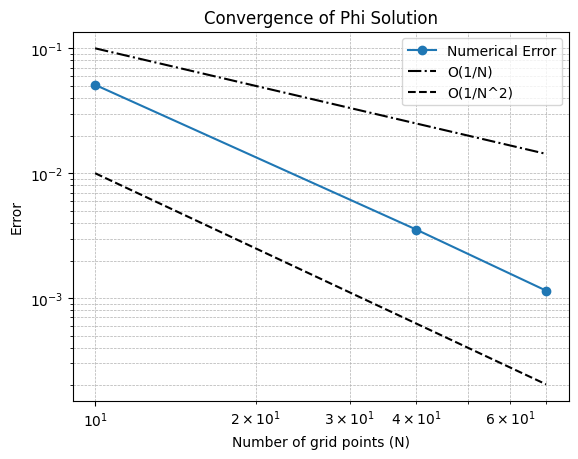

In [10]:
NMPI = 1
GENERALIZED = True
TEST_ANALYTICAL = True
SOLVER_TYPE = "GMRES"

error_phi_data = []
error_rho_data = []
error_n_data = []

for nx in range(10, 100, 30):
    ny = nx

    try:
        stdout_output = run_poisson_solver(NMPI, nx, ny, SOLVER_TYPE, GENERALIZED, TEST_ANALYTICAL)
        # If parse_muelu_output is needed: extracted_data = parse_muelu_output(stdout_output)
    except CalledProcessError as e:
        print(f"Error running command: {e.cmd}")
        print(f"Return code: {e.returncode}")
        print(f"STDOUT: {e.stdout}")
        print(f"STDERR: {e.stderr}")
        continue

    x = linspace(0, 1, nx)
    y = linspace(0, 1, ny)
    X, Y = meshgrid(x, y, indexing='ij')

    phi_numerical = read_tpetra_output('phi', nx, ny)
    phi_analytical = vectorize(phi_exact)(X, Y)
    error_phi_data.append([nx, get_error(phi_numerical, phi_analytical)])
    print(f"Error in phi for nx={nx}: {error_phi_data[-1][1]}")

    rho_numerical = read_tpetra_output('rhs', nx, ny)
    rho_analytical = vectorize(calculate_rho if GENERALIZED else calculate_rho_const)(X, Y)
    error_rho_data.append([nx, get_error(rho_numerical, rho_analytical)])
    print(f"Error in rho for nx={nx}: {error_rho_data[-1][1]}")

    if GENERALIZED:
        n_numerical = read_tpetra_output('n', nx, ny)
        n_analytical = vectorize(calculate_n)(X, Y)
        error_n_data.append([nx, get_error(n_numerical, n_analytical)])
        print(f"Error in n for nx={nx}: {error_n_data[-1][1]}")

plot_convergence(error_phi_data, 'Convergence of Phi Solution')


In [366]:
print(stdout_output)

verbosity = high
coarse: max size = 32
cycle type = W
max levels = 10
number of equations = 1   [default]
rap: algorithm = galerkin   [default]
level 0 -> 
 smoother: type = RELAXATION
 rap: algorithm = galerkin   [default]
 smoother: params -> 
  relaxation: type = Symmetric Gauss-Seidel   [unused]
  relaxation: damping factor = 1   [unused]
  relaxation: sweeps = 2   [unused]
level 1 -> 
 smoother: type = RELAXATION
 rap: algorithm = galerkin   [default]
 smoother: params -> 
  relaxation: type = Symmetric Gauss-Seidel   [unused]
  relaxation: damping factor = 1   [unused]
  relaxation: sweeps = 3   [unused]
level 2 -> 
 smoother: type = RELAXATION
 rap: algorithm = galerkin   [default]
 smoother: params -> 
  relaxation: type = Symmetric Gauss-Seidel   [unused]
  relaxation: damping factor = 1   [unused]
  relaxation: sweeps = 4   [unused]
level 3 -> 
 smoother: type = RELAXATION
 rap: algorithm = galerkin   [default]
 smoother: params -> 
  relaxation: type = Symmetric Gauss-Seidel

Maximum error in n: 4.993783164763954e-13


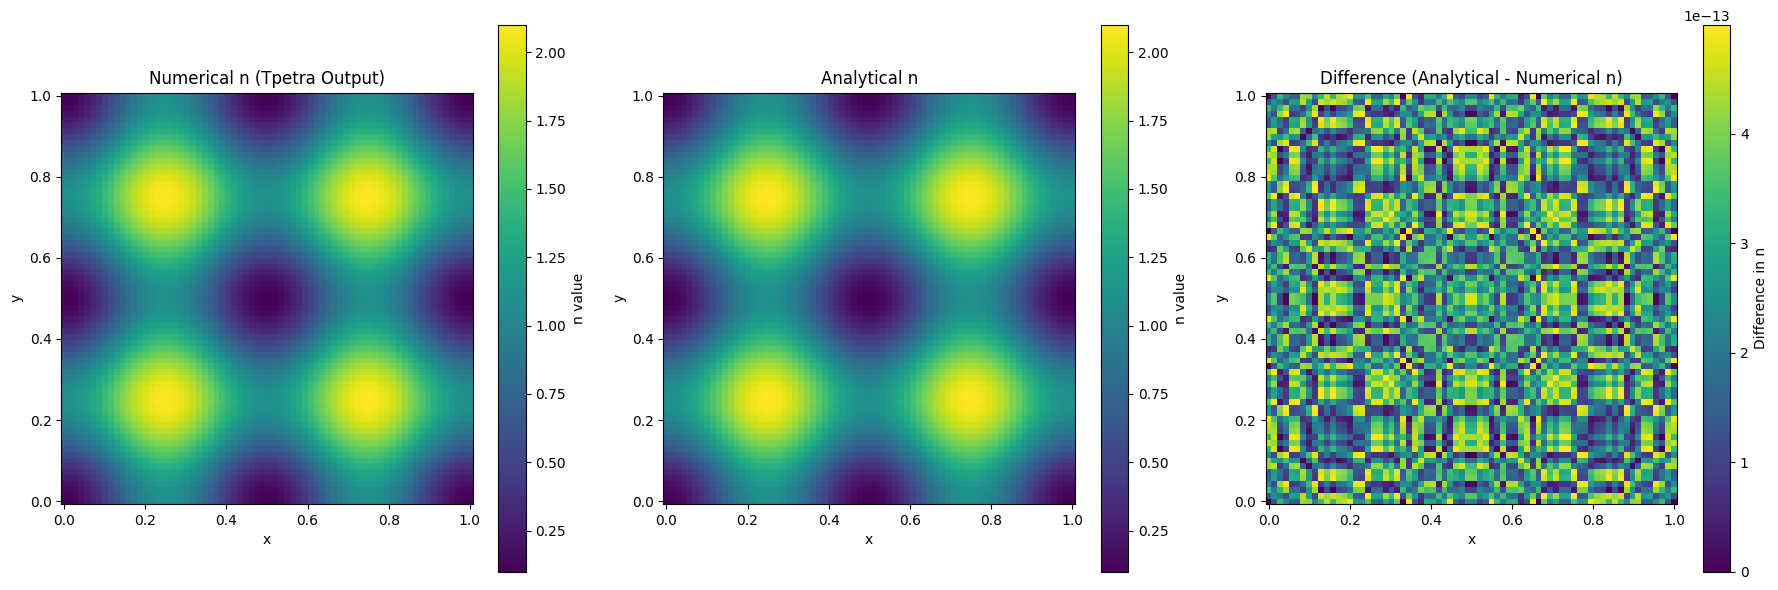

In [367]:
if GENERALIZED:
    n_data = read_tpetra_output("n", nx=nx, ny=nx)
    plot_comparison(n_data, vectorize(calculate_n)(X,Y), x, y, X, Y, title_prefix="n")

Maximum error in rho: 5.044853423896711e-13


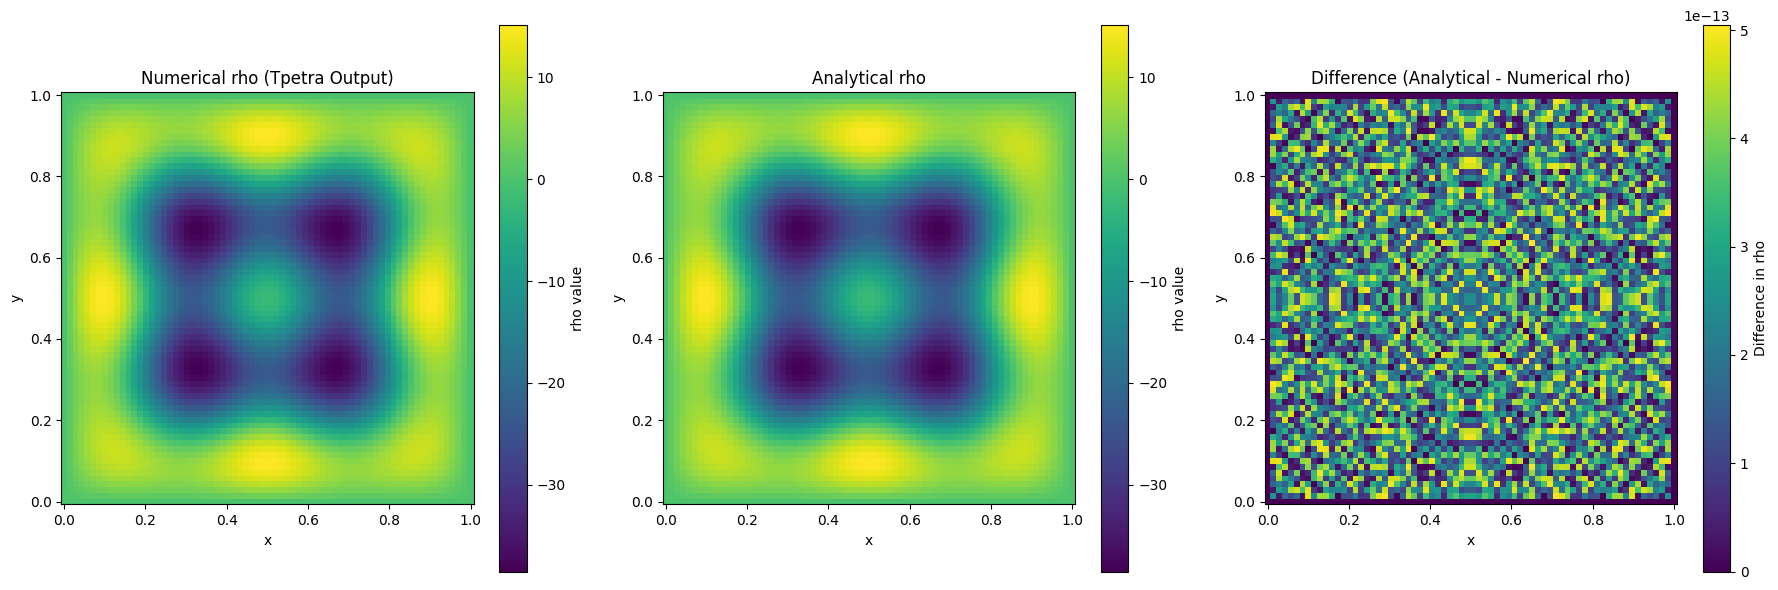

In [368]:
data = read_tpetra_output("rhs", nx=nx, ny=nx)
comp = vectorize(calculate_rho)(X, Y) if GENERALIZED else vectorize(calculate_rho_const)(X, Y)
plot_comparison(data, comp, x, y, X, Y, title_prefix="rho")

Maximum error in phi: 0.001148273330862426


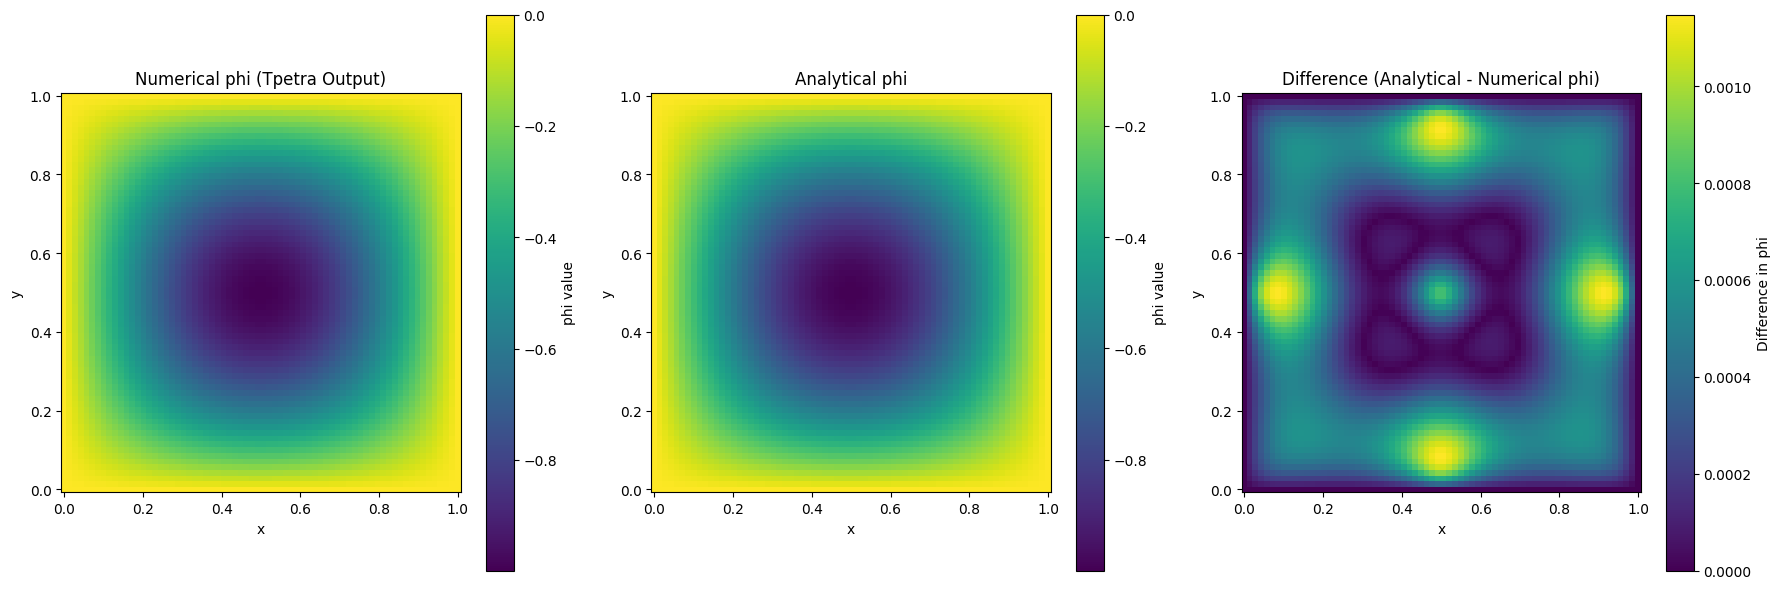

In [369]:
data = read_tpetra_output("phi", nx=nx, ny=nx)
plot_comparison(data, vectorize(phi_exact)(X,Y), x, y, X, Y, title_prefix="phi")

In [13]:
NMPI = 1
OMP_NUM_THREADS = 1
GENERALIZED = True
TEST_ANALYTICAL = False
SOLVER_TYPES = ["GMRES", "CG"]

In [14]:

def run_once(NMPI, nx, solver_type, OMP_NUM_THREADS):
    try:
        stdout_output = run_poisson_solver(NMPI, nx, nx, solver_type, GENERALIZED, TEST_ANALYTICAL, nthreads=OMP_NUM_THREADS)
        extracted_data = parse_belos_solver_summary(stdout_output) # Assuming this extracts iters, residual, time
        multigrid_data = extract_multigrid_summary(stdout_output)
        print(f"Nx: {nx}, Number of levels: {multigrid_data['Number of levels']}")
        print(f"Solver: {solver_type}, Iterations: {extracted_data[0]}, Final Residual: {extracted_data[1]}, Solve Time: {extracted_data[2]} seconds")

    except CalledProcessError as e:
        print(f"Error running command: {e.cmd}")
        print(f"Return code: {e.returncode}")
        print(f"STDOUT: {e.stdout}")
        print(f"STDERR: {e.stderr}")
        stdout_output=e.stdout
    return stdout_output


In [21]:
nx = 2048
ny = nx
solver_type = "CG"

stdout_output= run_once(1,nx,solver_type,1)

Nx: 2048, Number of levels: 7
Solver: CG, Iterations: 10, Final Residual: 1.1908e-13, Solve Time: 7.402 seconds


[ 2.60697731 27.45587288 82.61535459 26.14403033  7.75599473  9.41653484
 68.03117127 23.27911006 24.65364692 19.04895868]


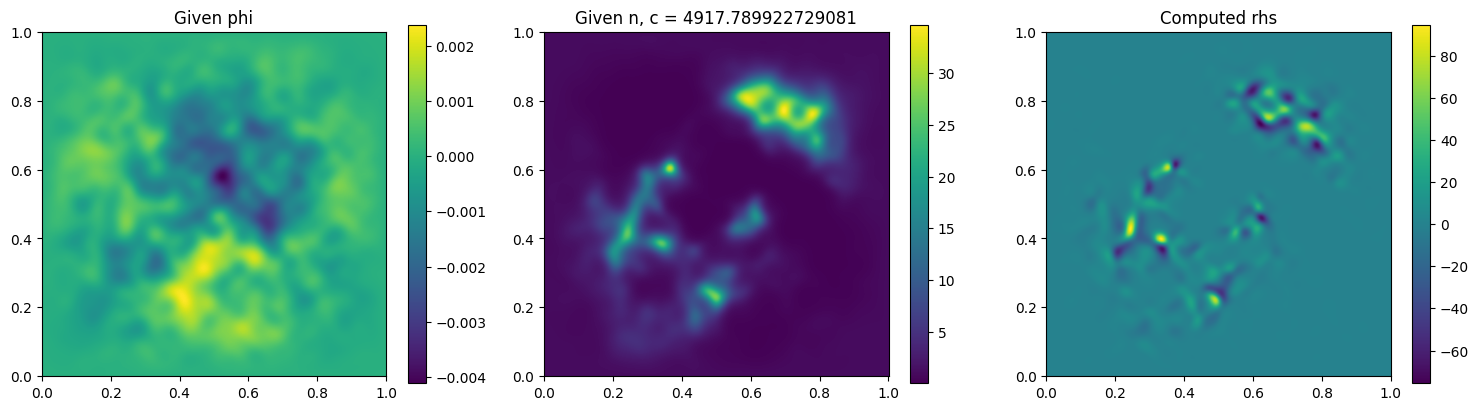

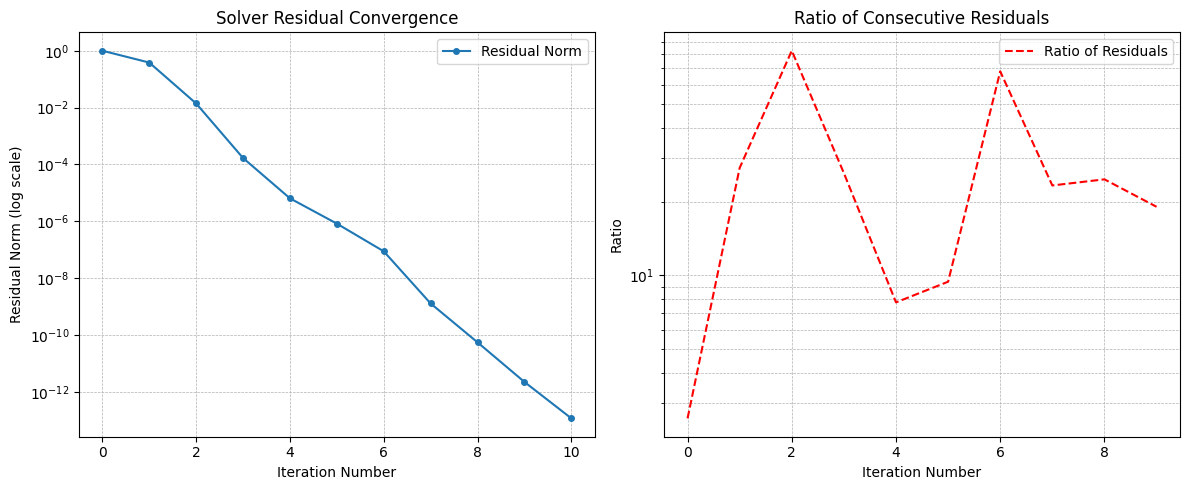

In [25]:
phidata = read_tpetra_output("phi0", nx=nx, ny=nx)
rhodata = read_tpetra_output("rhs", nx=nx, ny=nx)



x = linspace(0, 1, nx)
y = linspace(0, 1, ny)
X, Y = meshgrid(x, y, indexing='ij')

fig, ax = subplots(1,3,figsize=(15, 4))
im0 = ax[0].pcolor(x, y, phidata, shading='auto')
ax[0].set_title('Given phi')
ax[0].set_aspect('equal')
colorbar(im0, ax=ax[0])
if GENERALIZED:
    ndata = read_tpetra_output("n", nx=nx, ny=nx)
    im1 = ax[1].pcolor(x, y, ndata, shading='auto')
    colorbar(im1, ax=ax[1])
    ax[1].set_aspect('equal')
    ax[1].set_title('Given n, c = ' + str(amax(ndata)/amin(ndata)))
im2 = ax[2].pcolor(x, y, rhodata, shading='auto')
ax[2].set_title('Computed rhs')
colorbar(im2, ax=ax[2])
ax[2].set_aspect('equal')
fig.tight_layout()

res = plot_error_evolution_simplified(stdout_output)

In [24]:
print(stdout_output)

Kokkos execution space: N6Kokkos6OpenMPE
Running on execution space in initializataoin: N6Kokkos6OpenMPE
Running on execution space in initializataoin: N6Kokkos6OpenMPE
Running on execution space in initializataoin: N6Kokkos6OpenMPE
verbosity = high
coarse: max size = 32
cycle type = W
max levels = 10
number of equations = 1   [default]
rap: algorithm = galerkin   [default]
level 0 -> 
 smoother: type = RELAXATION
 rap: algorithm = galerkin   [default]
 smoother: params -> 
  relaxation: type = Symmetric Gauss-Seidel   [unused]
  relaxation: damping factor = 1   [unused]
  relaxation: sweeps = 2   [unused]
level 1 -> 
 smoother: type = RELAXATION
 rap: algorithm = galerkin   [default]
 smoother: params -> 
  relaxation: type = Symmetric Gauss-Seidel   [unused]
  relaxation: damping factor = 1   [unused]
  relaxation: sweeps = 3   [unused]
level 2 -> 
 smoother: type = RELAXATION
 rap: algorithm = galerkin   [default]
 smoother: params -> 
  relaxation: type = Symmetric Gauss-Seidel   [

Maximum error in phi: 1.0000000502143058e-12


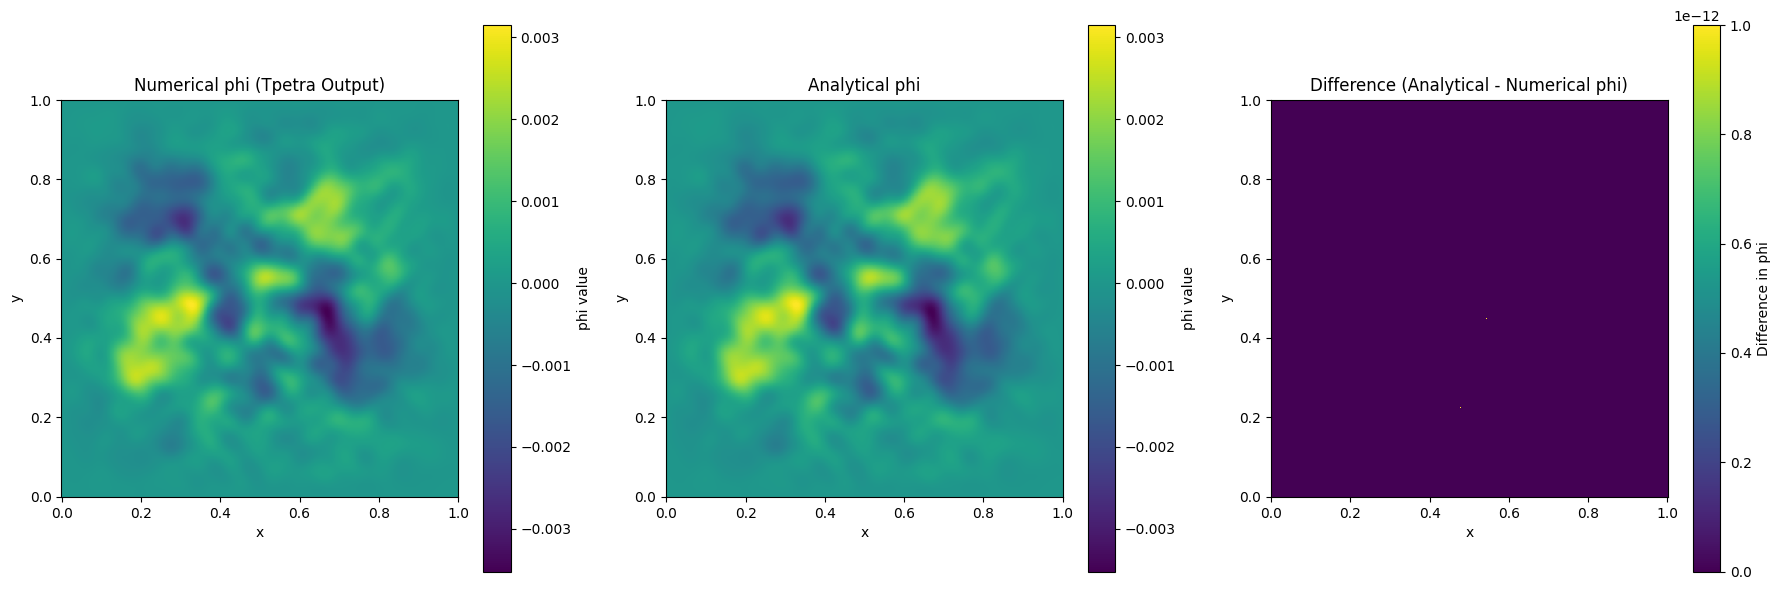

In [375]:
phi0 = read_tpetra_output("phi0", nx=nx, ny=nx)
phi = read_tpetra_output("phi", nx=nx, ny=nx)

plot_comparison(phi, phi0, x, y, X, Y, title_prefix="phi")

In [376]:


solver_performance_data = {solver: [] for solver in SOLVER_TYPES}

for solver_type in SOLVER_TYPES:
    for inx in range(3,12,1):

        nx = 2**inx
        ny = nx
        
        extracted_data = run_once(1,nx, solver_type, 1)
        solver_performance_data[solver_type].append((nx, extracted_data[0], extracted_data[1], extracted_data[2]))


Nx: 8, Number of levels: 2
Solver: GMRES, Iterations: 7, Final Residual: 1.66616e-17, Solve Time: 0.004477 seconds
Nx: 16, Number of levels: 2
Solver: GMRES, Iterations: 10, Final Residual: 4.71351e-16, Solve Time: 0.003226 seconds
Nx: 32, Number of levels: 3
Solver: GMRES, Iterations: 12, Final Residual: 5.67112e-17, Solve Time: 0.006715 seconds
Nx: 64, Number of levels: 4
Solver: GMRES, Iterations: 301, Final Residual: 1.02513e-16, Solve Time: 1.156 seconds
Nx: 128, Number of levels: 5
Solver: GMRES, Iterations: 499, Final Residual: 1.60778e-16, Solve Time: 6.749 seconds
Nx: 256, Number of levels: 5
Solver: GMRES, Iterations: 499, Final Residual: 9.78479e-17, Solve Time: 24.52 seconds
Nx: 512, Number of levels: 6
Solver: GMRES, Iterations: 499, Final Residual: 5.65131e-16, Solve Time: 93.06 seconds
Error running command: ['mpirun', '-n', '1', '../build/Poisson', '--nx=1024', '--ny=1024', '--solver=GMRES', '--generalized']
Return code: 132
STDOUT: 
STDERR: ----------------------------

IndexError: string index out of range

In [ ]:
max_size = int([line for line in stdout_output.splitlines() if "coarse: max size" in line][0].split('=')[1])


fig, ax = subplots(2,1,figsize=(10, 6), sharex=True)
data = solver_performance_data
for solver in data:
    nx_values = [entry[0] for entry in data[solver]]
    iterations = [entry[1] for entry in data[solver]]
    ax[0].plot(nx_values, iterations, marker='o', label=solver)
ax[0].set_ylabel('Iterations')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[0].legend()

for solver in data:
    nx_values = [entry[0] for entry in data[solver]]
    times = [entry[3] for entry in data[solver]]
    ax[1].plot(nx_values, times, marker='o', label=solver)
ax[1].plot([sqrt(max_size), sqrt(max_size)], [amin(times), max(times)], 'k--', label='Limit coarse solver', linewidth=1.5)
ax[1].set_xlabel('Grid Size (nx)')
ax[1].set_ylabel('Time to Solution (seconds)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].legend()
fig.tight_layout()

ValueError: zero-size array to reduction operation minimum which has no identity

Error in callback <function _draw_all_if_interactive at 0x77e214180f40> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x600 with 2 Axes>

In [95]:
for NMPI in range(1,5):
    for nomp in range(1,5):
        run_once(NMPI, 128, "CG", nomp)

Nx: 128, Number of levels: 5
Solver: CG, Iterations: 6, Final Residual: 5.0181e-11, Solve Time: 0.02314 seconds
Nx: 128, Number of levels: 4
Solver: CG, Iterations: 6, Final Residual: 7.00498e-11, Solve Time: 0.02319 seconds
Nx: 128, Number of levels: 4
Solver: CG, Iterations: 6, Final Residual: 7.31576e-11, Solve Time: 0.02736 seconds
Nx: 128, Number of levels: 4
Solver: CG, Iterations: 6, Final Residual: 9.47426e-11, Solve Time: 0.02895 seconds
Nx: 128, Number of levels: 5
Solver: CG, Iterations: 6, Final Residual: 4.20019e-11, Solve Time: 0.02208 seconds
Nx: 128, Number of levels: 4
Solver: CG, Iterations: 8, Final Residual: 7.00283e-12, Solve Time: 0.01857 seconds
Nx: 128, Number of levels: 4
Solver: CG, Iterations: 8, Final Residual: 8.59989e-12, Solve Time: 0.03333 seconds
Nx: 128, Number of levels: 4
Solver: CG, Iterations: 6, Final Residual: 7.35726e-11, Solve Time: 0.04052 seconds
Nx: 128, Number of levels: 5
Solver: CG, Iterations: 6, Final Residual: 8.45807e-11, Solve Time: 